# Imports and constant

In [1]:
import kagglehub
import pandas as pd
import numpy as np
import warnings
import math
import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, LabelBinarizer, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import RocCurveDisplay, make_scorer, classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import ValidationCurveDisplay, LearningCurveDisplay, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle


from scipy.stats import randint

warnings.filterwarnings("ignore")

RD_STATE = 42
TEST_SIZE = 0.25


c:\Users\pierr\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Get the datasets from kaggle

By doing so, you can get the datasets only with the code

In [2]:
# Download latest version
sch_path = kagglehub.dataset_download("uom190346a/global-coffee-health-dataset")

print("Path to dataset file:", sch_path)

sch_db = pd.read_csv(sch_path + '/synthetic_coffee_health_10000.csv')
sch_db

Path to dataset file: C:\Users\pierr\.cache\kagglehub\datasets\uom190346a\global-coffee-health-dataset\versions\1


,ID,Age,Gender,Country,Coffee_Intake,Caffeine_mg,Sleep_Hours,Sleep_Quality,BMI,Heart_Rate,Stress_Level,Physical_Activity_Hours,Health_Issues,Occupation,Smoking,Alcohol_Consumption
0,1,40,Male,Germany,3.5,328.1,7.5,Good,24.9,78,Low,14.5,NaN,Other,0,0
1,2,33,Male,Germany,1.0,94.1,6.2,Good,20.0,67,Low,11.0,NaN,Service,0,0
2,3,42,Male,Brazil,5.3,503.7,5.9,Fair,22.7,59,Medium,11.2,Mild,Office,0,0
3,4,53,Male,Germany,2.6,249.2,7.3,Good,24.7,71,Low,6.6,Mild,Other,0,0
4,5,32,Female,Spain,3.1,298.0,5.3,Fair,24.1,76,Medium,8.5,Mild,Student,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,50,Female,Japan,2.1,199.8,6.0,Fair,30.5,50,Medium,10.1,Moderate,Healthcare,0,1
9996,9997,18,Female,UK,3.4,319.2,5.8,Fair,19.1,71,Medium,11.6,Mild,Service,0,0
9997,9998,26,Male,China,1.6,153.4,7.1,Good,25.1,66,Low,13.7,NaN,Student,1,1
9998,9999,40,Female,Finland,3.4,327.1,7.0,Good,19.3,80,Low,0.1,NaN,Student,0,0


# Explonatory data analysis

In [3]:
# Check the dataset
for col in sch_db.columns:
    print(col, sch_db[col].isnull().sum(), end=" ")
    print(sch_db[col].unique())

# Check dataset
sch_db.dtypes

ID 0 [    1     2     3 ...  9998  9999 10000]
Age 0 [40 33 42 53 32 44 29 41 37 18 28 22 38 24 52 35 36 21 39 27 31 57 34 20
 19 43 26 47 30 46 51 25 45 64 48 61 23 50 67 80 62 60 56 54 49 59 58 71
 55 65 66 63 73 72 68 70 69 77 75]
Gender 0 ['Male' 'Female' 'Other']
Country 0 ['Germany' 'Brazil' 'Spain' 'Mexico' 'France' 'Canada' 'UK' 'Switzerland'
 'Netherlands' 'Italy' 'China' 'Japan' 'Belgium' 'Finland' 'Australia'
 'USA' 'Sweden' 'India' 'Norway' 'South Korea']
Coffee_Intake 0 [3.5 1.  5.3 2.6 3.1 3.4 2.7 4.5 1.7 4.  4.1 4.7 1.4 3.2 4.3 0.7 2.2 0.
 2.4 4.6 0.4 1.9 0.8 2.5 1.5 2.8 4.4 3.8 2.  3.3 2.1 3.6 1.6 1.1 0.9 4.9
 0.1 5.4 1.3 0.6 1.8 2.9 4.2 2.3 3.9 1.2 7.6 0.2 7.1 5.2 0.5 3.7 5.  6.2
 3.  4.8 5.1 7.3 5.8 5.9 6.1 5.5 5.7 6.4 0.3 5.6 6.7 6.  6.5 6.3 8.2 7.2
 7.  6.6 7.8 6.8 7.7 6.9]
Caffeine_mg 0 [328.1  94.1 503.7 ... 460.2 509.1  59.1]
Sleep_Hours 0 [ 7.5  6.2  5.9  7.3  5.3  6.4  7.8  5.5  7.1  8.1  6.5  6.9  6.6  6.8
  7.7  5.7  5.   6.1  6.   8.3  9.2  7.9  4.8  7.4  7.

ID                           int64
Age                          int64
Gender                      object
Country                     object
Coffee_Intake              float64
Caffeine_mg                float64
Sleep_Hours                float64
Sleep_Quality               object
BMI                        float64
Heart_Rate                   int64
Stress_Level                object
Physical_Activity_Hours    float64
Health_Issues               object
Occupation                  object
Smoking                      int64
Alcohol_Consumption          int64
dtype: object

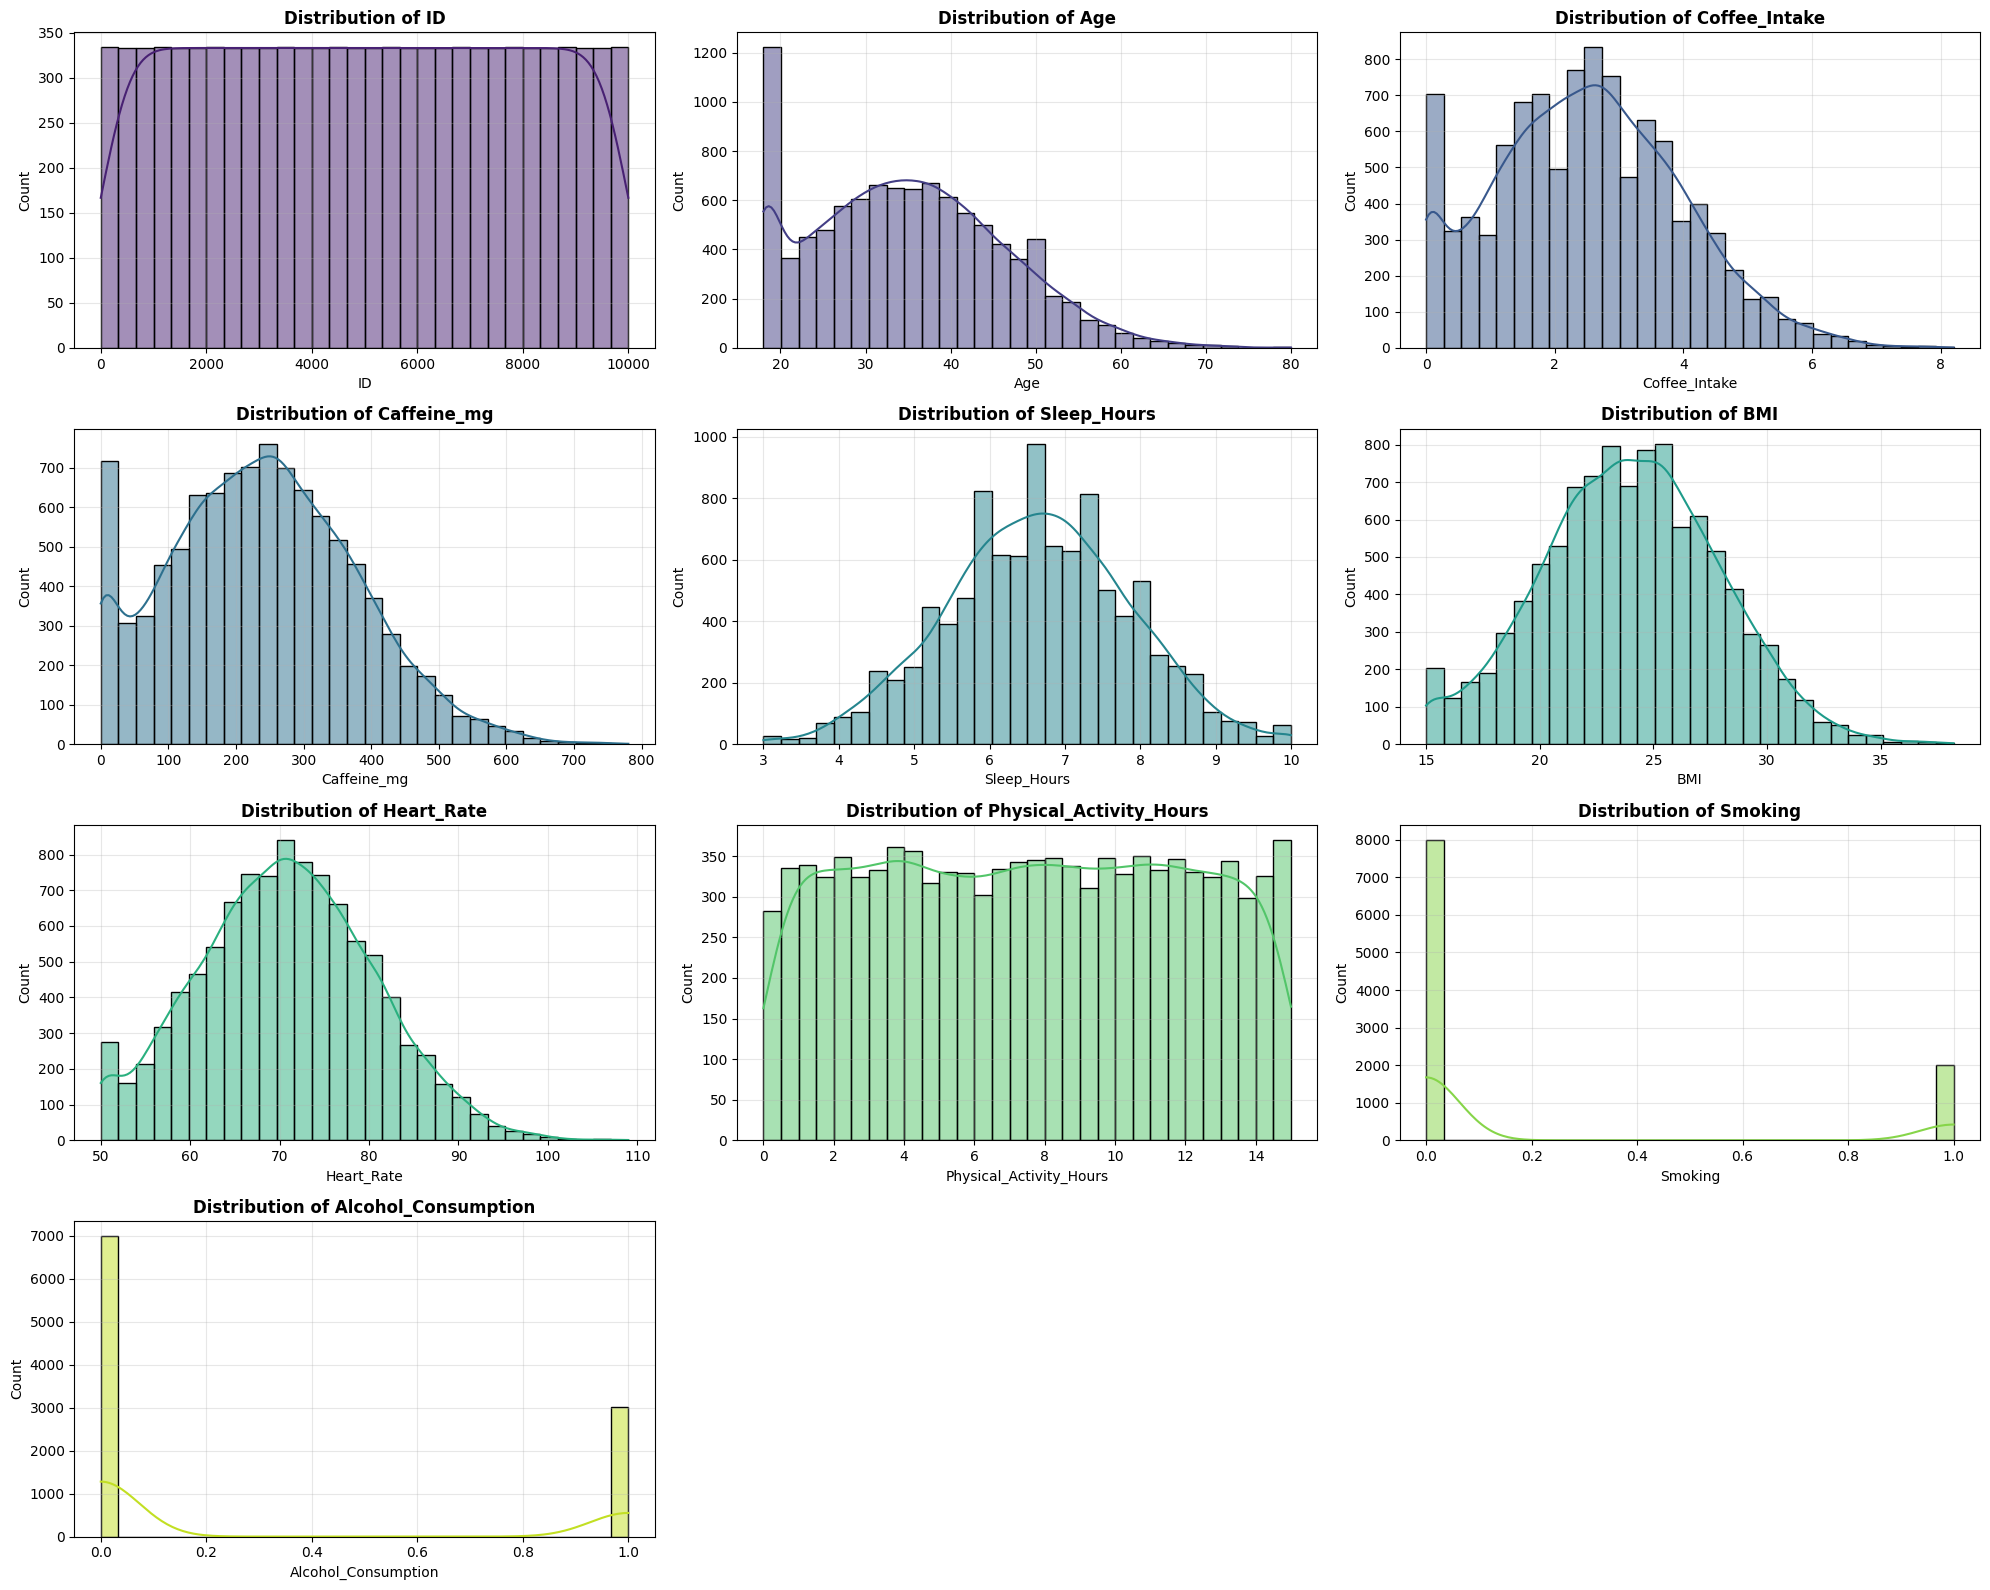

In [4]:
# Check distribution
numerical_cols = sch_db.select_dtypes(include=['int64', 'float64']).columns

def plot_numeric_distributions(df, cols):
    n = len(cols)
    rows = int(np.ceil(n / 3))
    palette = sns.color_palette("viridis", n)
    plt.figure(figsize=(20, rows * 4))
    for i, col in enumerate(cols, 1):
        plt.subplot(rows, 3, i)
        sns.histplot(df[col], kde=True, bins=30, color=palette[i-1])
        plt.title(f"Distribution of {col}", fontsize=12, fontweight='bold')
        plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    
plot_numeric_distributions(sch_db, numerical_cols)


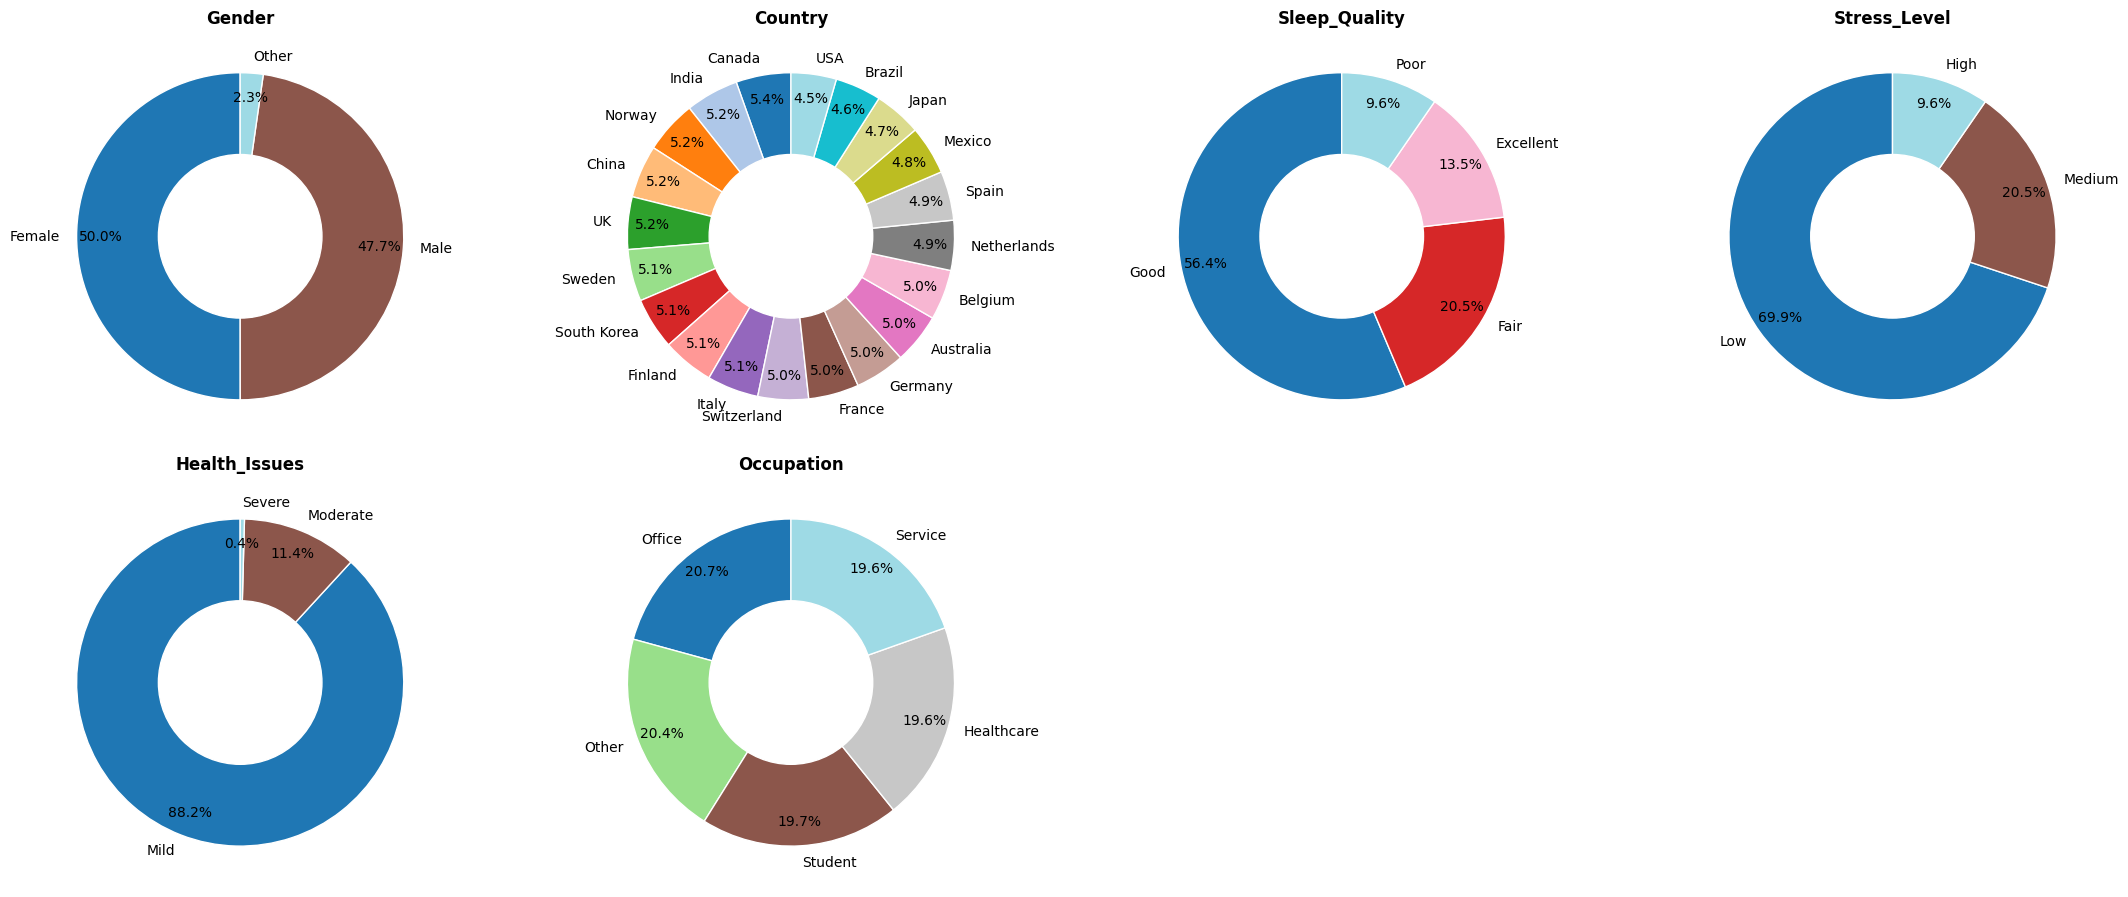

In [5]:
# Check percentage
plt.figure(figsize=(22, 18))

categorical_cols = sch_db.select_dtypes(include=['object', 'category']).columns
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(4, 4, i)
    sch_db[col].value_counts().plot.pie(
        autopct='%1.1f%%',
        startangle=90,
        pctdistance=0.85,
        textprops={'fontsize': 10},
        wedgeprops={"linewidth": 1, "edgecolor": "white"},
        cmap="tab20"
    )
    centre_circle = plt.Circle((0,0),0.50,color='white', fc='white')
    plt.gca().add_artist(centre_circle)
    plt.title(f"{col}", fontsize=12, fontweight='bold')
    plt.ylabel("")

plt.tight_layout()
plt.show()

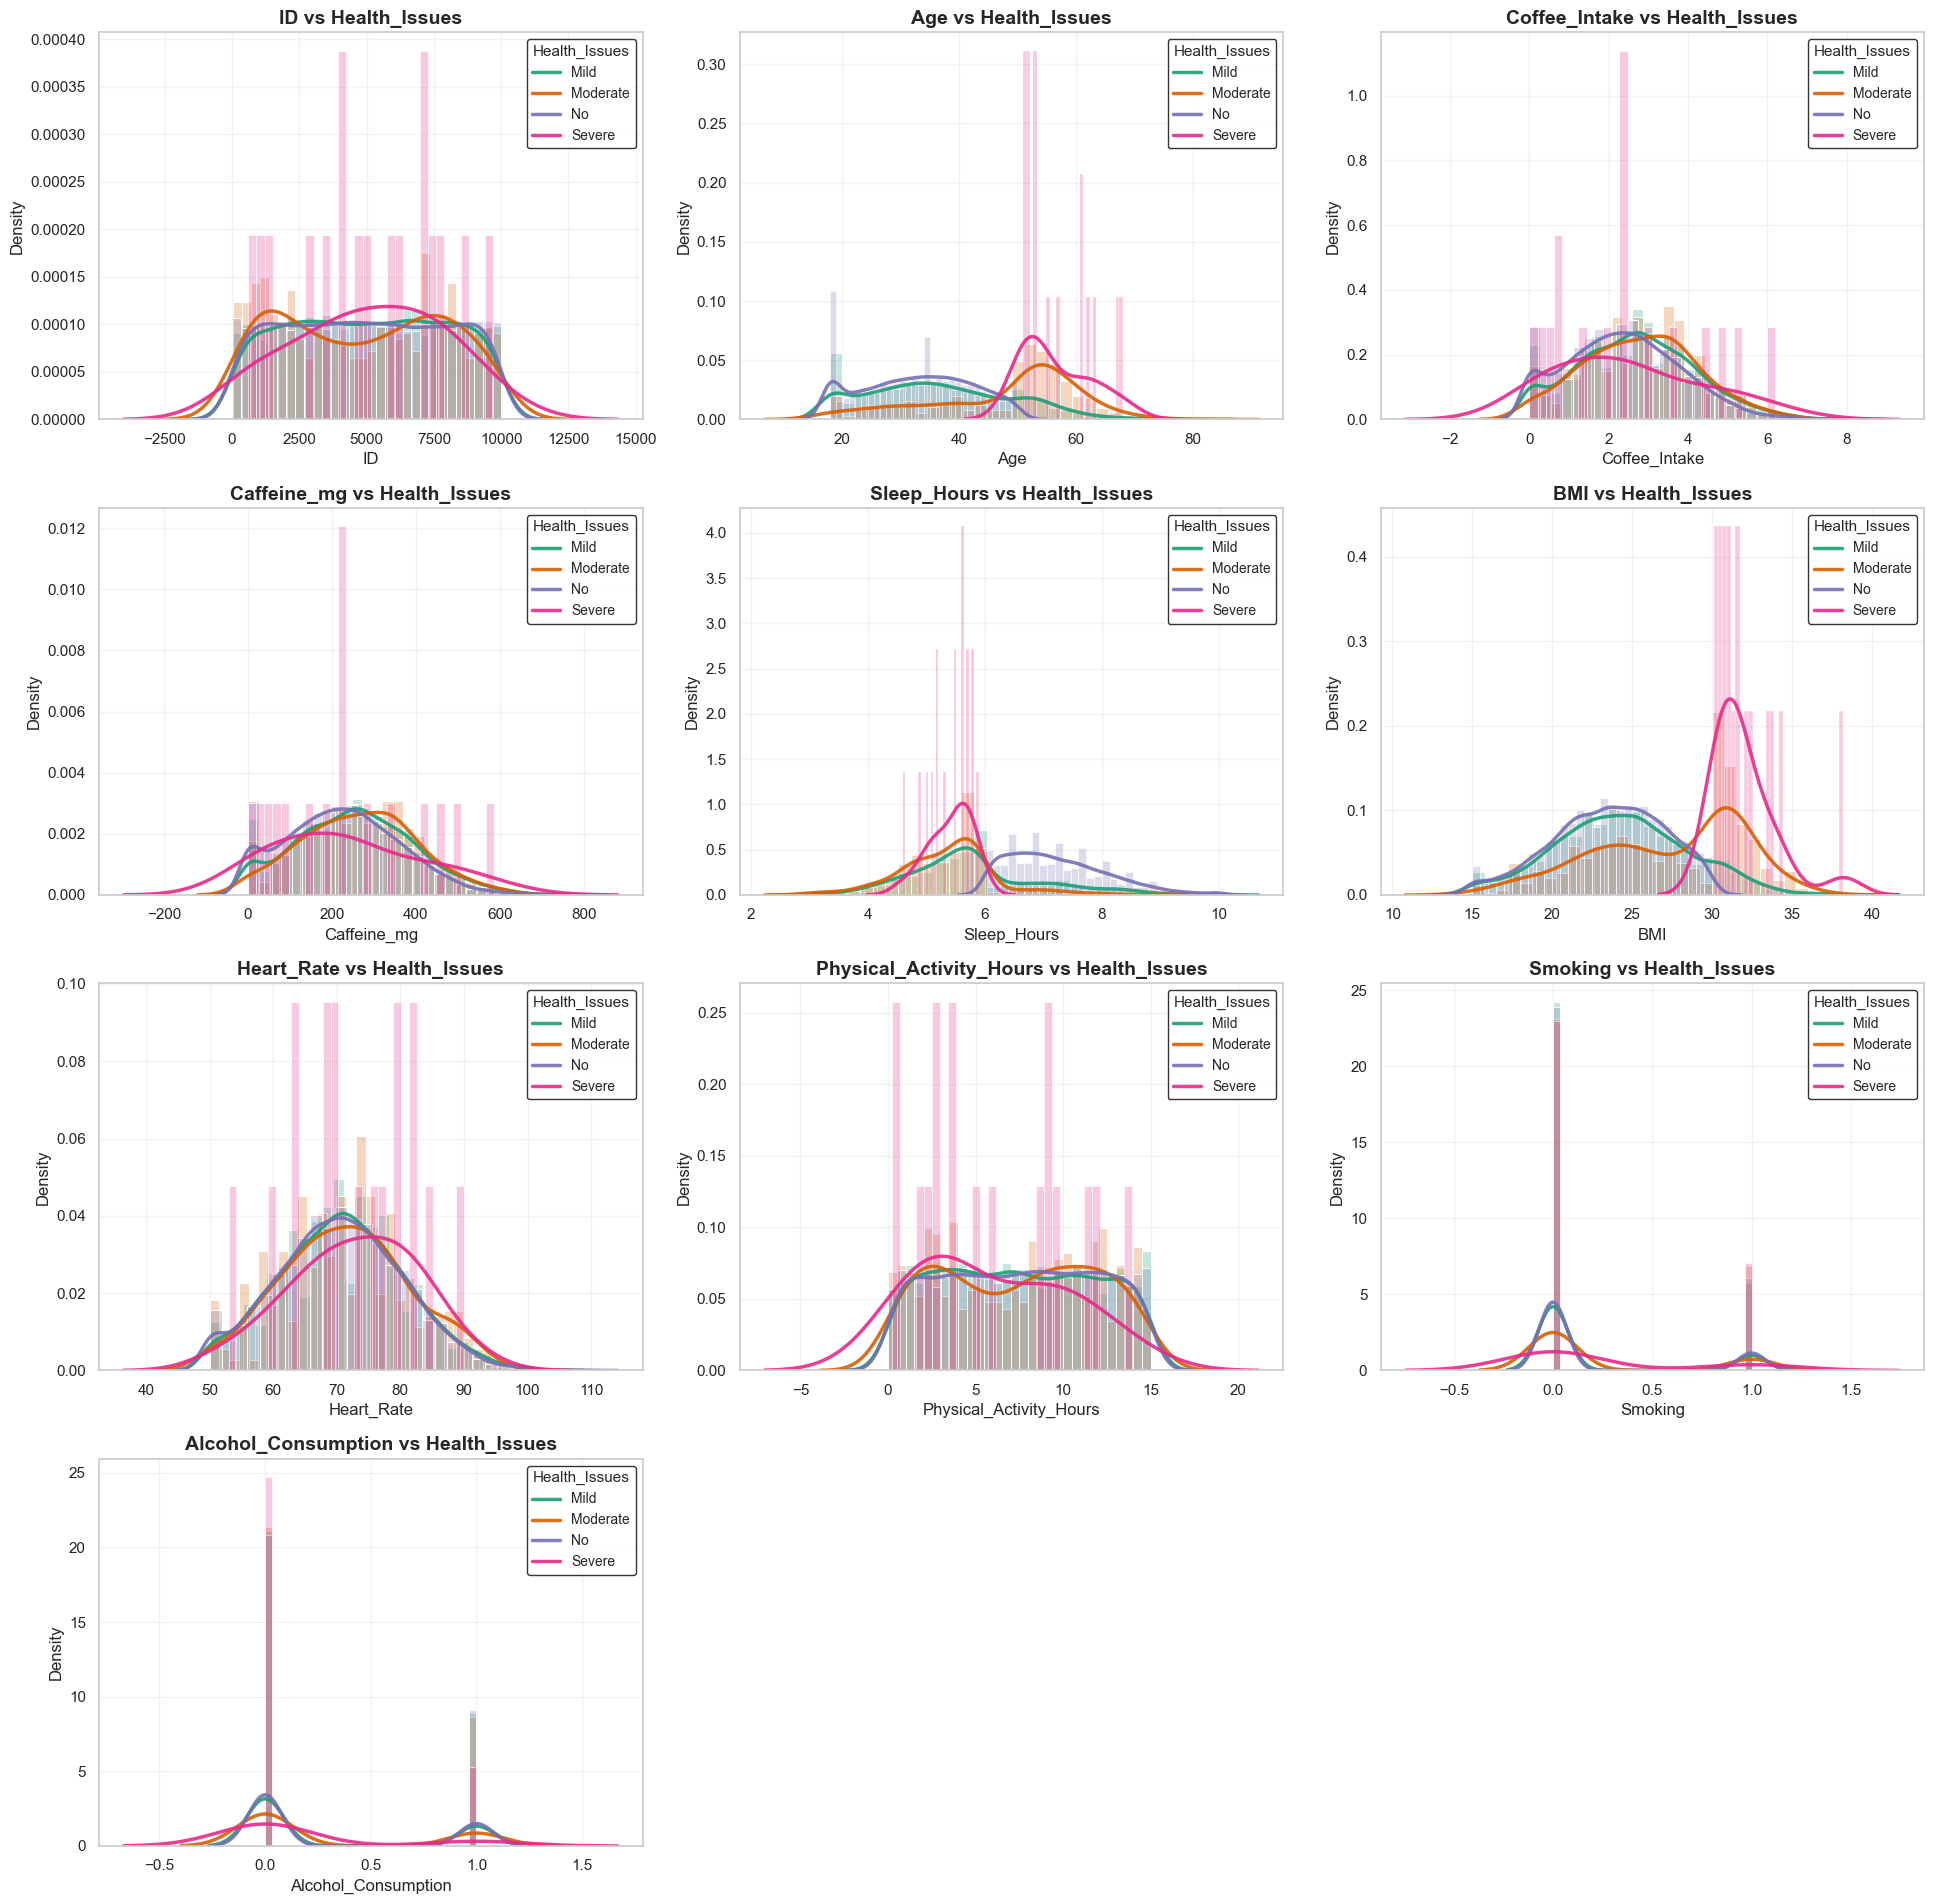

In [6]:
def plot_histograms_by_target(df, target='Health_Issues', exclude_cols=None, bins=30, cols_per_row=3, palette='Dark2'):
    sns.set(style="whitegrid")
    # Missing target values were temporarily imputed for visualization purposes only during EDA.
    df = df.copy()
    df[target].fillna('No', inplace=True)
    if exclude_cols is None:
        exclude_cols = []
    num_cols = [
        col for col in df.select_dtypes(include='number').columns
        if col not in exclude_cols + [target]
    ]
    n = len(num_cols)
    nrows = math.ceil(n / cols_per_row)
    fig, axes = plt.subplots(
        nrows,
        cols_per_row,
        figsize=(6.5 * cols_per_row, 4.8 * nrows)
    )
    axes = axes.flatten()
    unique_classes = sorted(df[target].unique())
    colors = sns.color_palette(palette, len(unique_classes))
    for i, col in enumerate(num_cols):
        ax = axes[i]
        for cls, color in zip(unique_classes, colors):
            subset = df[df[target] == cls][col]
            sns.kdeplot(
                subset,
                ax=ax,
                color=color,
                linewidth=2.5,
                label=str(cls),
                alpha=0.9
            )
            sns.histplot(
                subset,
                ax=ax,
                bins=bins,
                color=color,
                stat="density",
                alpha=0.25
            )
        ax.set_title(
            f"{col} vs {target}",
            fontsize=14,
            fontweight='bold'
        )
        ax.legend(
            title=target,
            fontsize=10,
            title_fontsize=11,
            frameon=True,
            facecolor="white",
            edgecolor="black"
        )
        ax.grid(alpha=0.25)
    for j in range(i + 1, len(axes)):
        axes[j].remove()
    plt.tight_layout()
    plt.show()

plot_histograms_by_target(sch_db, target='Health_Issues')

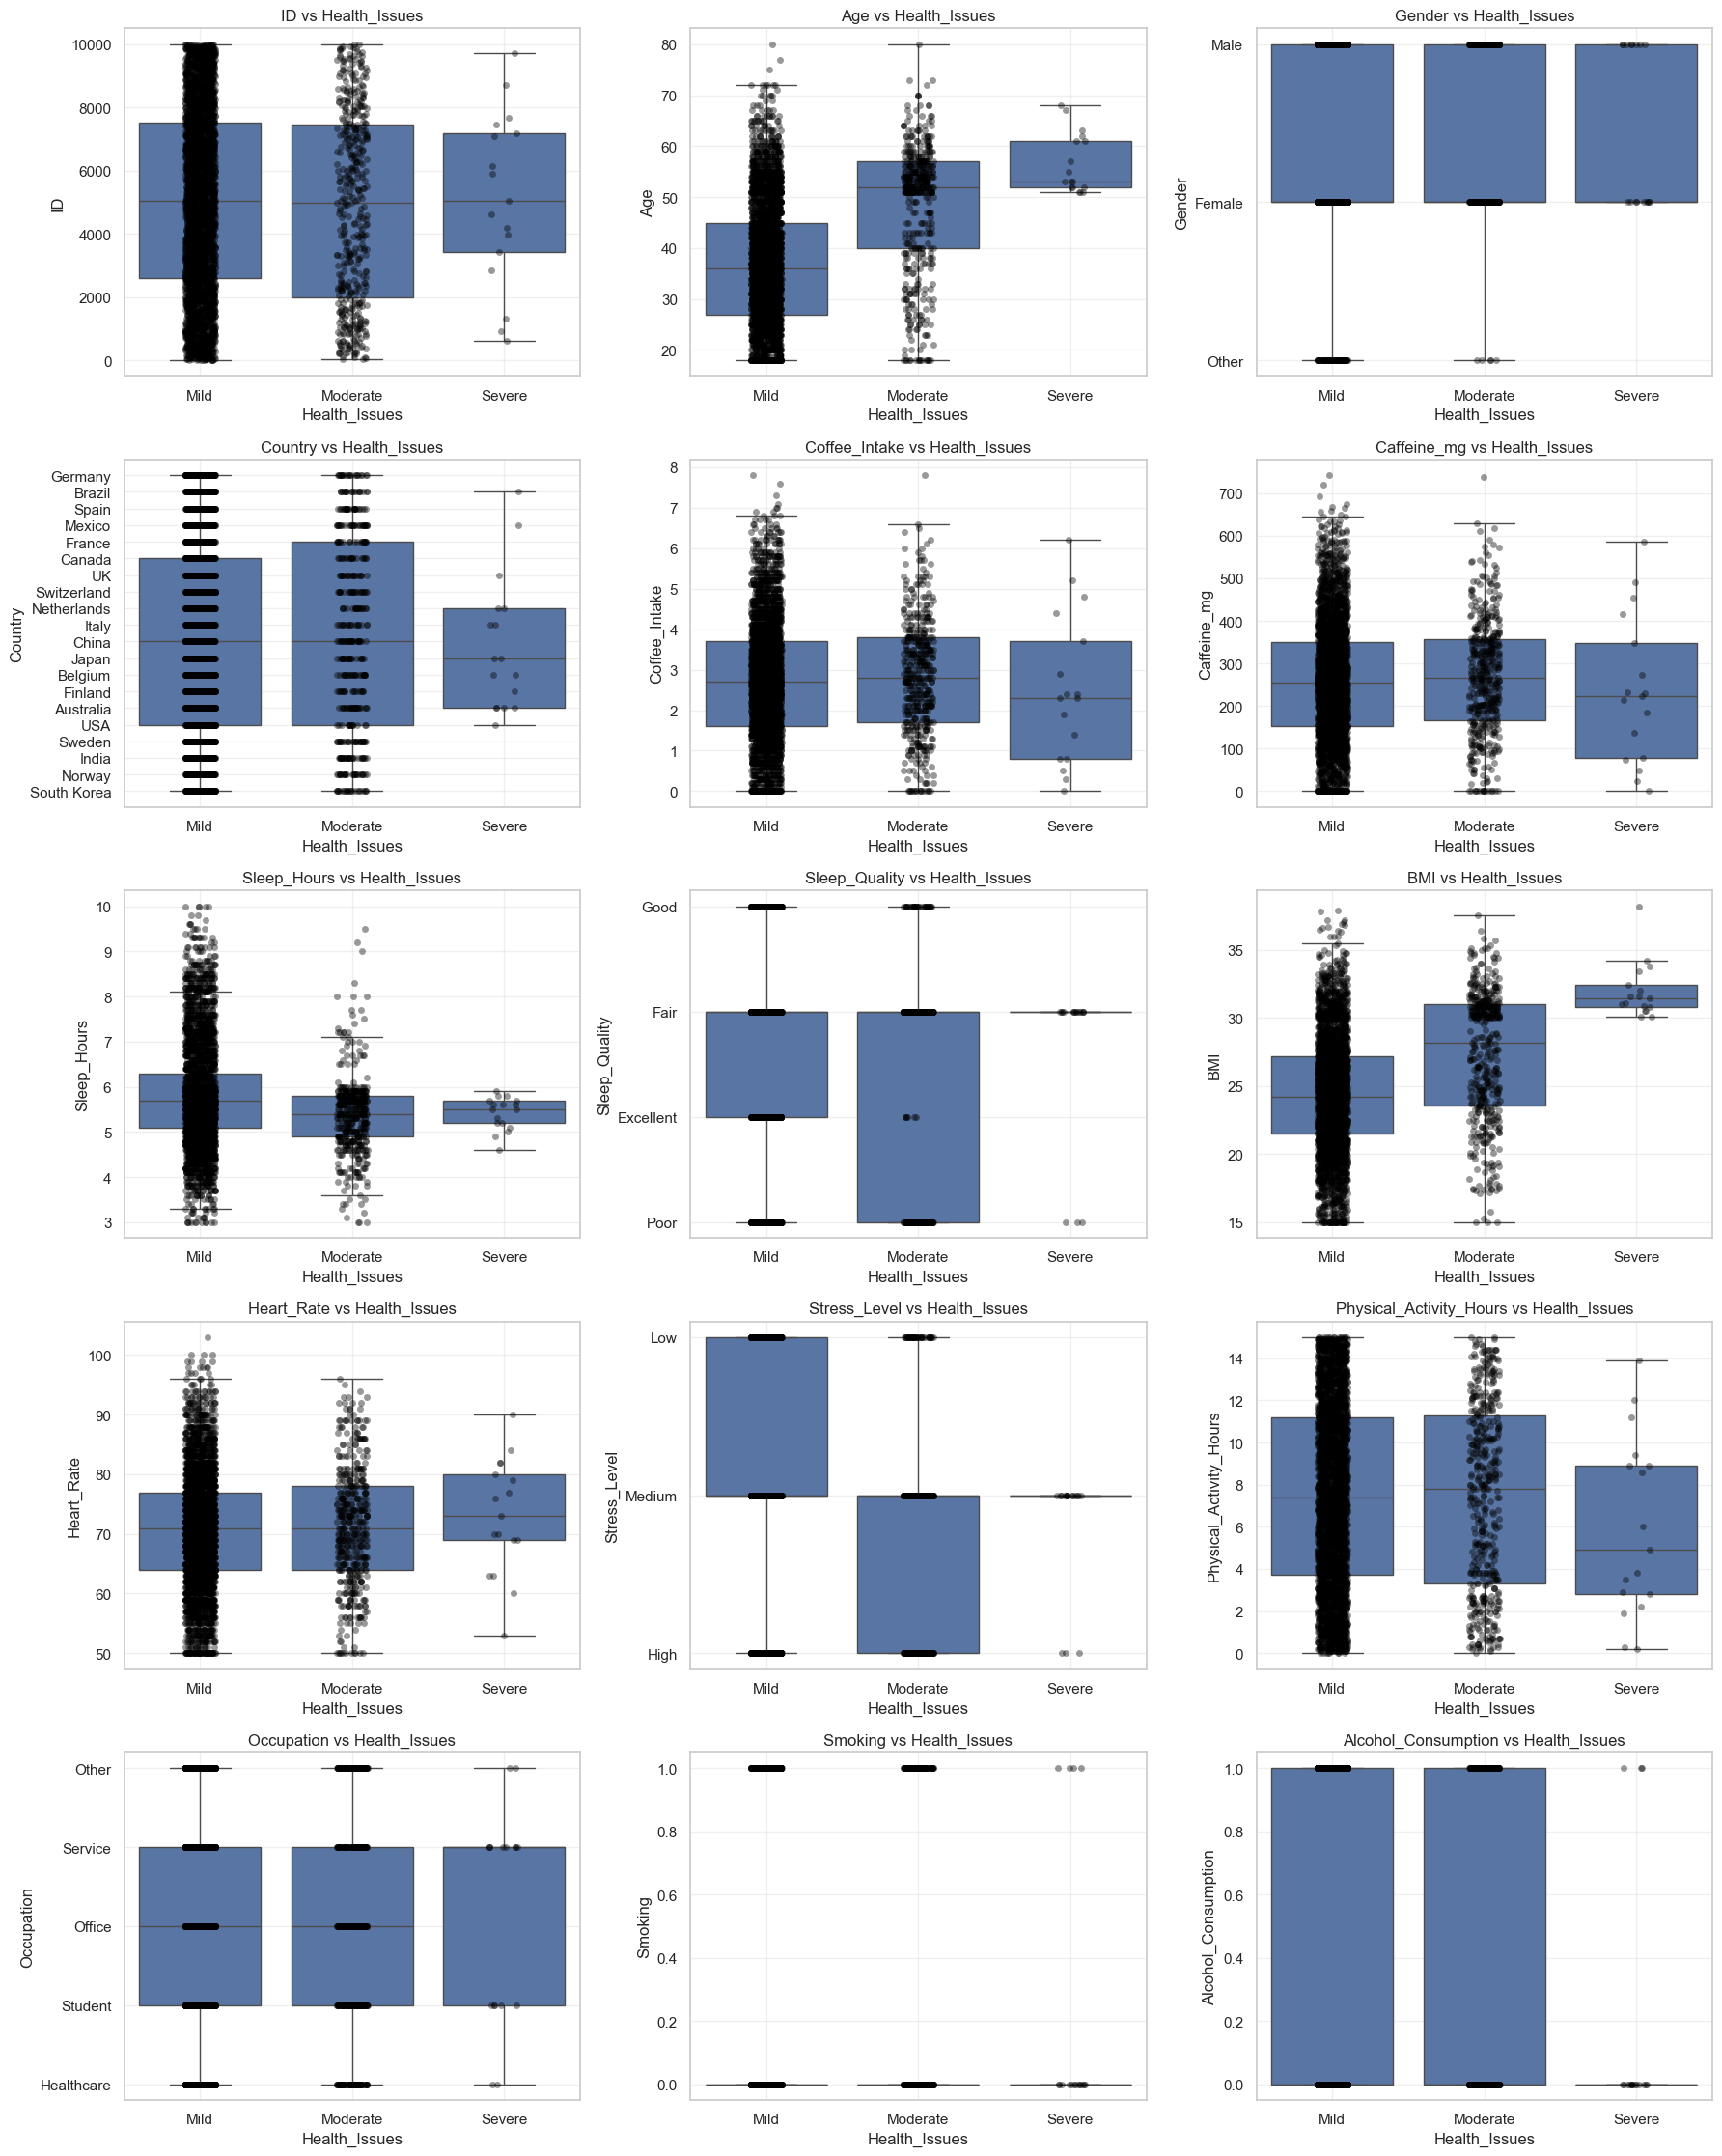

In [7]:
def show_plots(df, target='Health_Issues', cols_per_row=3, exclude_cols=None):
    if exclude_cols is None:
        exclude_cols = []

    cols = [col for col in df.columns if col not in exclude_cols + [target]]

    n = len(cols)
    nrows = math.ceil(n / cols_per_row)

    fig, axes = plt.subplots(
        nrows=nrows,
        ncols=cols_per_row,
        figsize=(6 * cols_per_row, 4.5 * nrows)
    )

    axes = axes.flatten()

    for i, col in enumerate(cols):
        ax = axes[i]

        sns.boxplot(
            x=target,
            y=col,
            data=df,
            ax=ax,
            showfliers=False
        )

        sns.stripplot(
            x=target,
            y=col,
            data=df,
            ax=ax,
            jitter=True,
            color="black",
            alpha=0.4
        )

        ax.set_title(f"{col} vs {target}")
        ax.grid(alpha=0.3)

    # Supprimer les axes vides
    for j in range(i + 1, len(axes)):
        axes[j].remove()

    plt.tight_layout()
    plt.show()

show_plots(sch_db, target='Health_Issues')

## **Data Cleaning**

* Goal: Fix or remove incorrect, corrupted, or incomplete data.
* Typical Tasks:
    * Handling missing values (e.g., imputation or deletion)
        + Done (removed NaN in Health Issues column) -> Replaced with 'No' class
    * Removing duplicates and irrelevant variables
        + Done (removed ID column)
    * Fixing data entry errors (e.g., inconsistent capitalization or typos)
        + Done 
    * Correcting inconsistencies (e.g., "USA" vs. "United States") and incomplete values
        + Done 
    * Handling outliers (depending on the use case)
        + Done (removed outliers with IQR method)


## 1. Handling missing values

In [8]:
# Check whether there is missing values or not -> 5941 null health_issues
sch_db.isnull().sum()


ID                            0
Age                           0
Gender                        0
Country                       0
Coffee_Intake                 0
Caffeine_mg                   0
Sleep_Hours                   0
Sleep_Quality                 0
BMI                           0
Heart_Rate                    0
Stress_Level                  0
Physical_Activity_Hours       0
Health_Issues              5941
Occupation                    0
Smoking                       0
Alcohol_Consumption           0
dtype: int64

In [9]:
# There are missing values in 'Health Issues'
# Let's assume rows without data in 'Health Issues' represent a person with good health
sch_db['Health_Issues'].fillna('No', inplace=True)
print(sch_db['Health_Issues'].unique())

# We have a problem with "severe" since it has too few data to be used properly
# We decided to mix "Moderate" and "Severe" into one single value "HighRisk".
sch_db['Health_Issues'] = sch_db['Health_Issues'].replace({
    'Severe': 'HighRisk',
    'Moderate': 'HighRisk'
})

sch_db['Health_Issues']

['No' 'Mild' 'Moderate' 'Severe']


0             No
1             No
2           Mild
3           Mild
4           Mild
          ...   
9995    HighRisk
9996        Mild
9997          No
9998          No
9999          No
Name: Health_Issues, Length: 10000, dtype: object

## 2. Removing duplicates and irrelevant variables

In [10]:
# Delete the "other" gender since useless for a health problem
sch_db = sch_db[sch_db['Gender'] != 'Other']
# Here, the 'ID' column is irrelevant for the ML algorithm, so we can just drop it
sch_db = sch_db.drop(["ID"], axis=1)
# Country creates to much features for KNN 
sch_db = sch_db.drop(["Country"], axis=1)
# We noticed that when you delete outliers (later in the project), it is equivalent to dropping this column since all values are the same (so we drop it now)
sch_db = sch_db.drop(["Smoking"], axis=1)
sch_db

,Age,Gender,Coffee_Intake,Caffeine_mg,Sleep_Hours,Sleep_Quality,BMI,Heart_Rate,Stress_Level,Physical_Activity_Hours,Health_Issues,Occupation,Alcohol_Consumption
0,40,Male,3.5,328.1,7.5,Good,24.9,78,Low,14.5,No,Other,0
1,33,Male,1.0,94.1,6.2,Good,20.0,67,Low,11.0,No,Service,0
2,42,Male,5.3,503.7,5.9,Fair,22.7,59,Medium,11.2,Mild,Office,0
3,53,Male,2.6,249.2,7.3,Good,24.7,71,Low,6.6,Mild,Other,0
4,32,Female,3.1,298.0,5.3,Fair,24.1,76,Medium,8.5,Mild,Student,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,50,Female,2.1,199.8,6.0,Fair,30.5,50,Medium,10.1,HighRisk,Healthcare,1
9996,18,Female,3.4,319.2,5.8,Fair,19.1,71,Medium,11.6,Mild,Service,0
9997,26,Male,1.6,153.4,7.1,Good,25.1,66,Low,13.7,No,Student,1
9998,40,Female,3.4,327.1,7.0,Good,19.3,80,Low,0.1,No,Student,0


## 3. Fixing data entry errors, Inconsistencies, Handling outliers

=====Age=====
count    9774.000000
mean       34.959382
std        11.170478
min        18.000000
25%        26.000000
50%        34.000000
75%        43.000000
max        80.000000
Name: Age, dtype: float64


=====Gender=====
Gender
Female    5001
Male      4773
Name: count, dtype: int64
count       9774
unique         2
top       Female
freq        5001
Name: Gender, dtype: object


=====Coffee_Intake=====
count    9774.000000
mean        2.509679
std         1.448631
min         0.000000
25%         1.500000
50%         2.500000
75%         3.500000
max         8.200000
Name: Coffee_Intake, dtype: float64


=====Caffeine_mg=====
count    9774.000000
mean      238.447729
std       137.595878
min         0.000000
25%       138.925000
50%       235.500000
75%       332.300000
max       780.300000
Name: Caffeine_mg, dtype: float64


=====Sleep_Hours=====
count    9774.000000
mean        6.637211
std         1.222802
min         3.000000
25%         5.800000
50%         6.600000
75%     

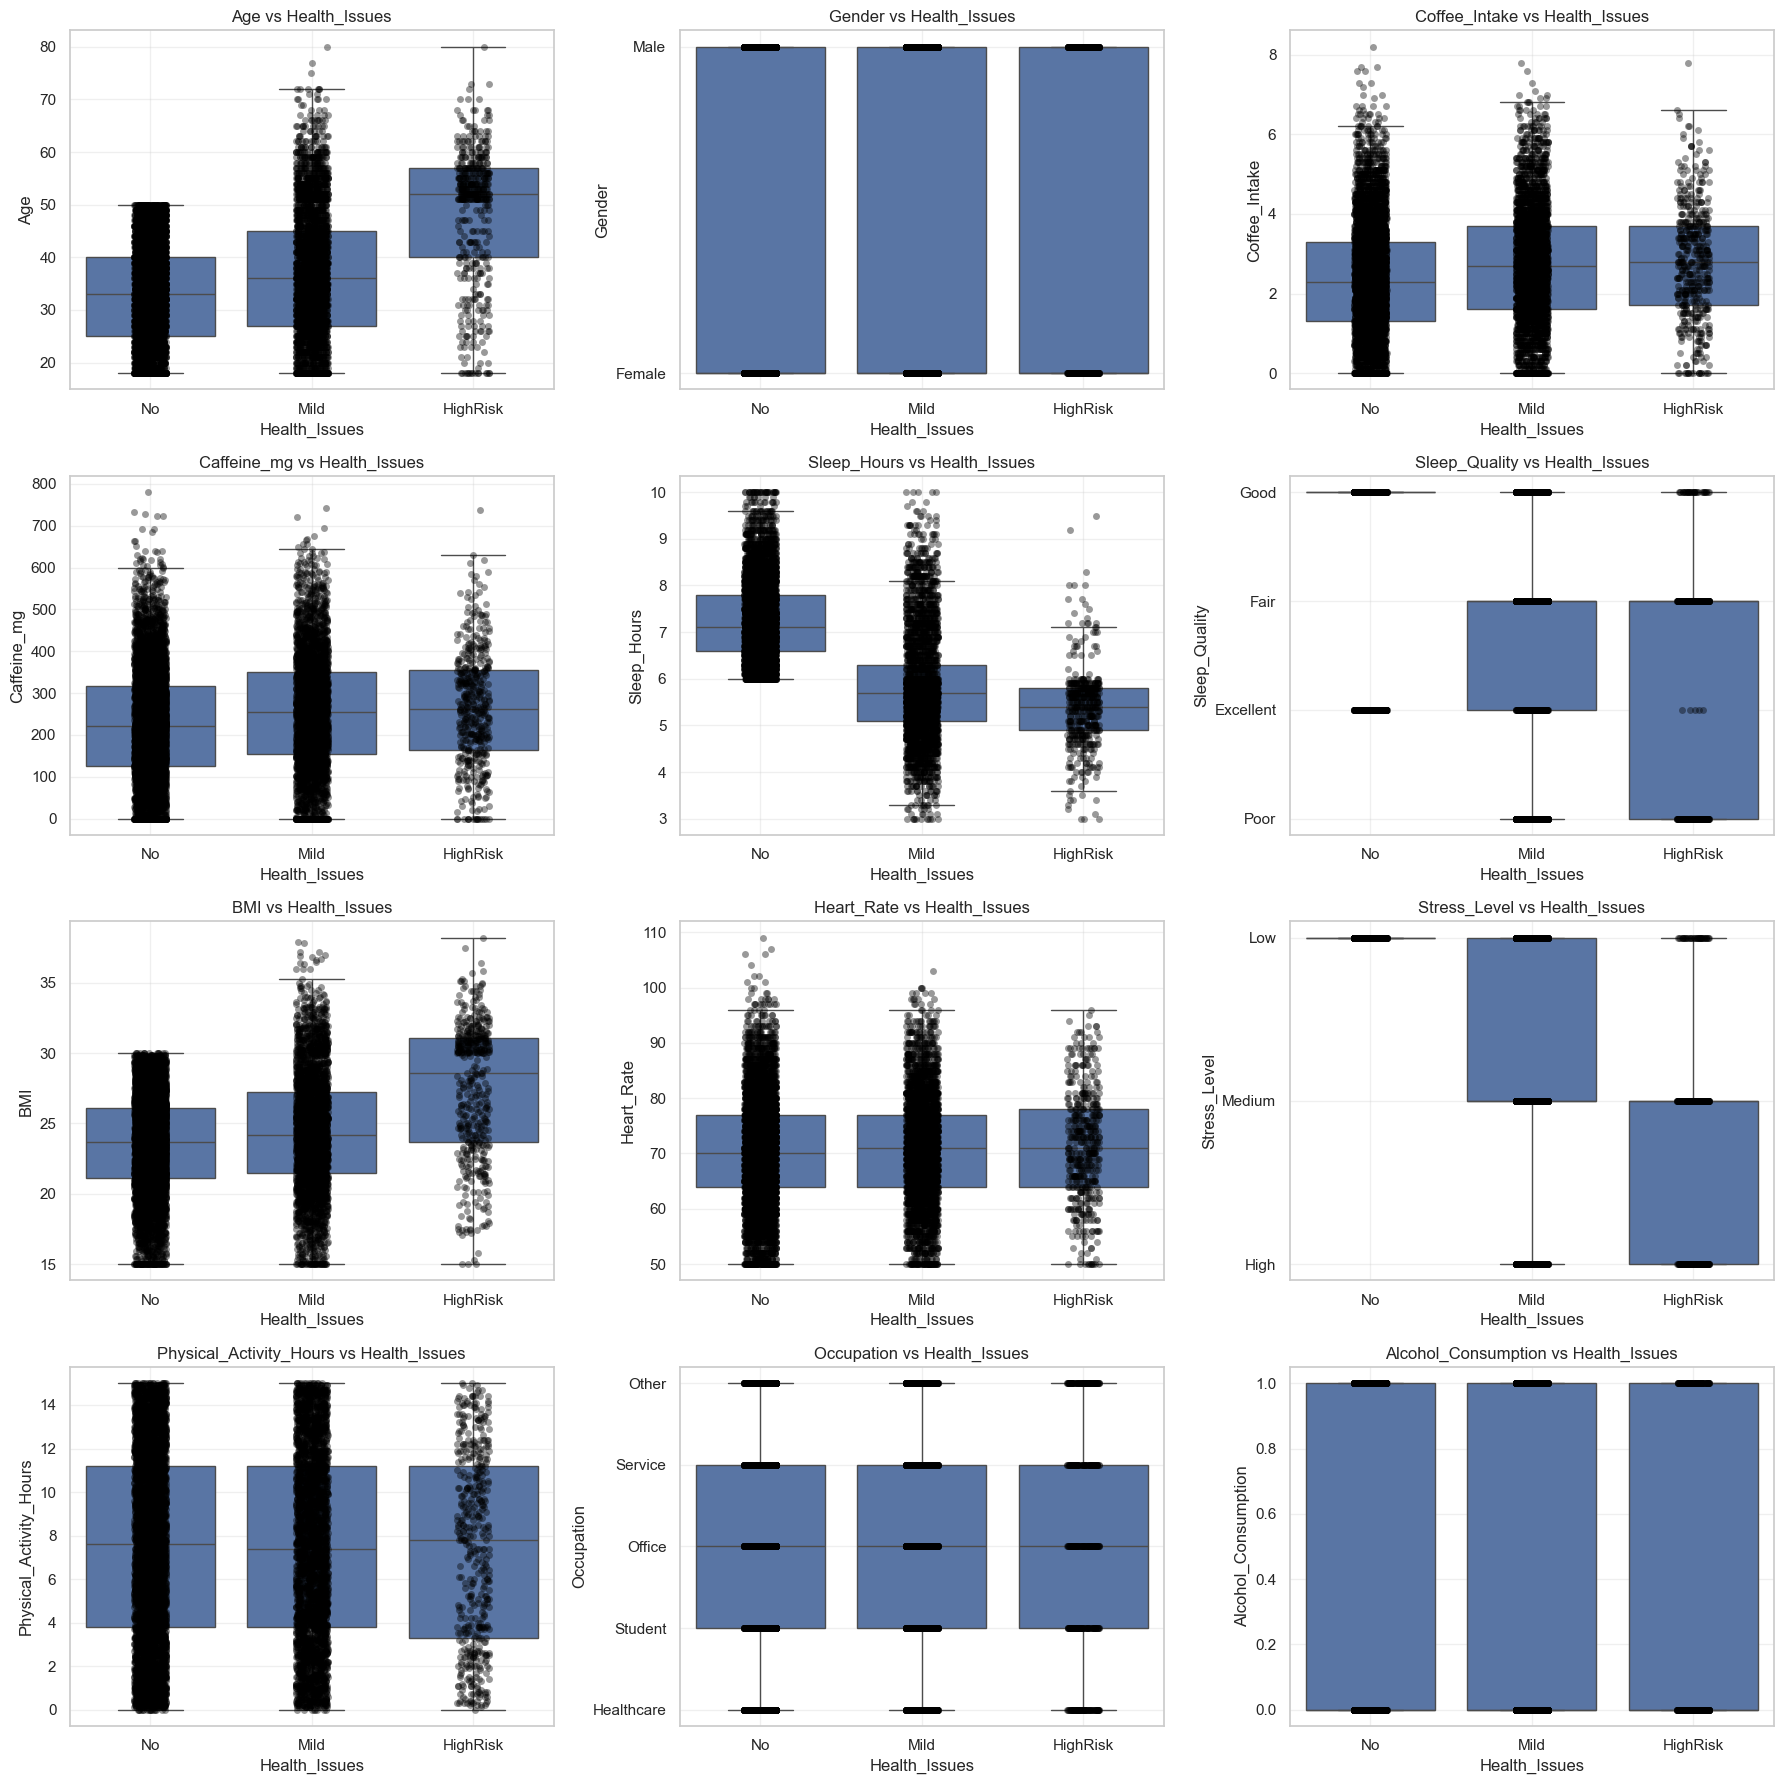

In [11]:
for col in sch_db.columns:
    print("=====" + col + "=====")
    if len(x := sch_db[col].value_counts()) < 50:
        print(x)
    print(sch_db[col].describe())
    print("\n")

show_plots(sch_db, target='Health_Issues')

int64
float64
float64
float64
float64
int64
float64
int64


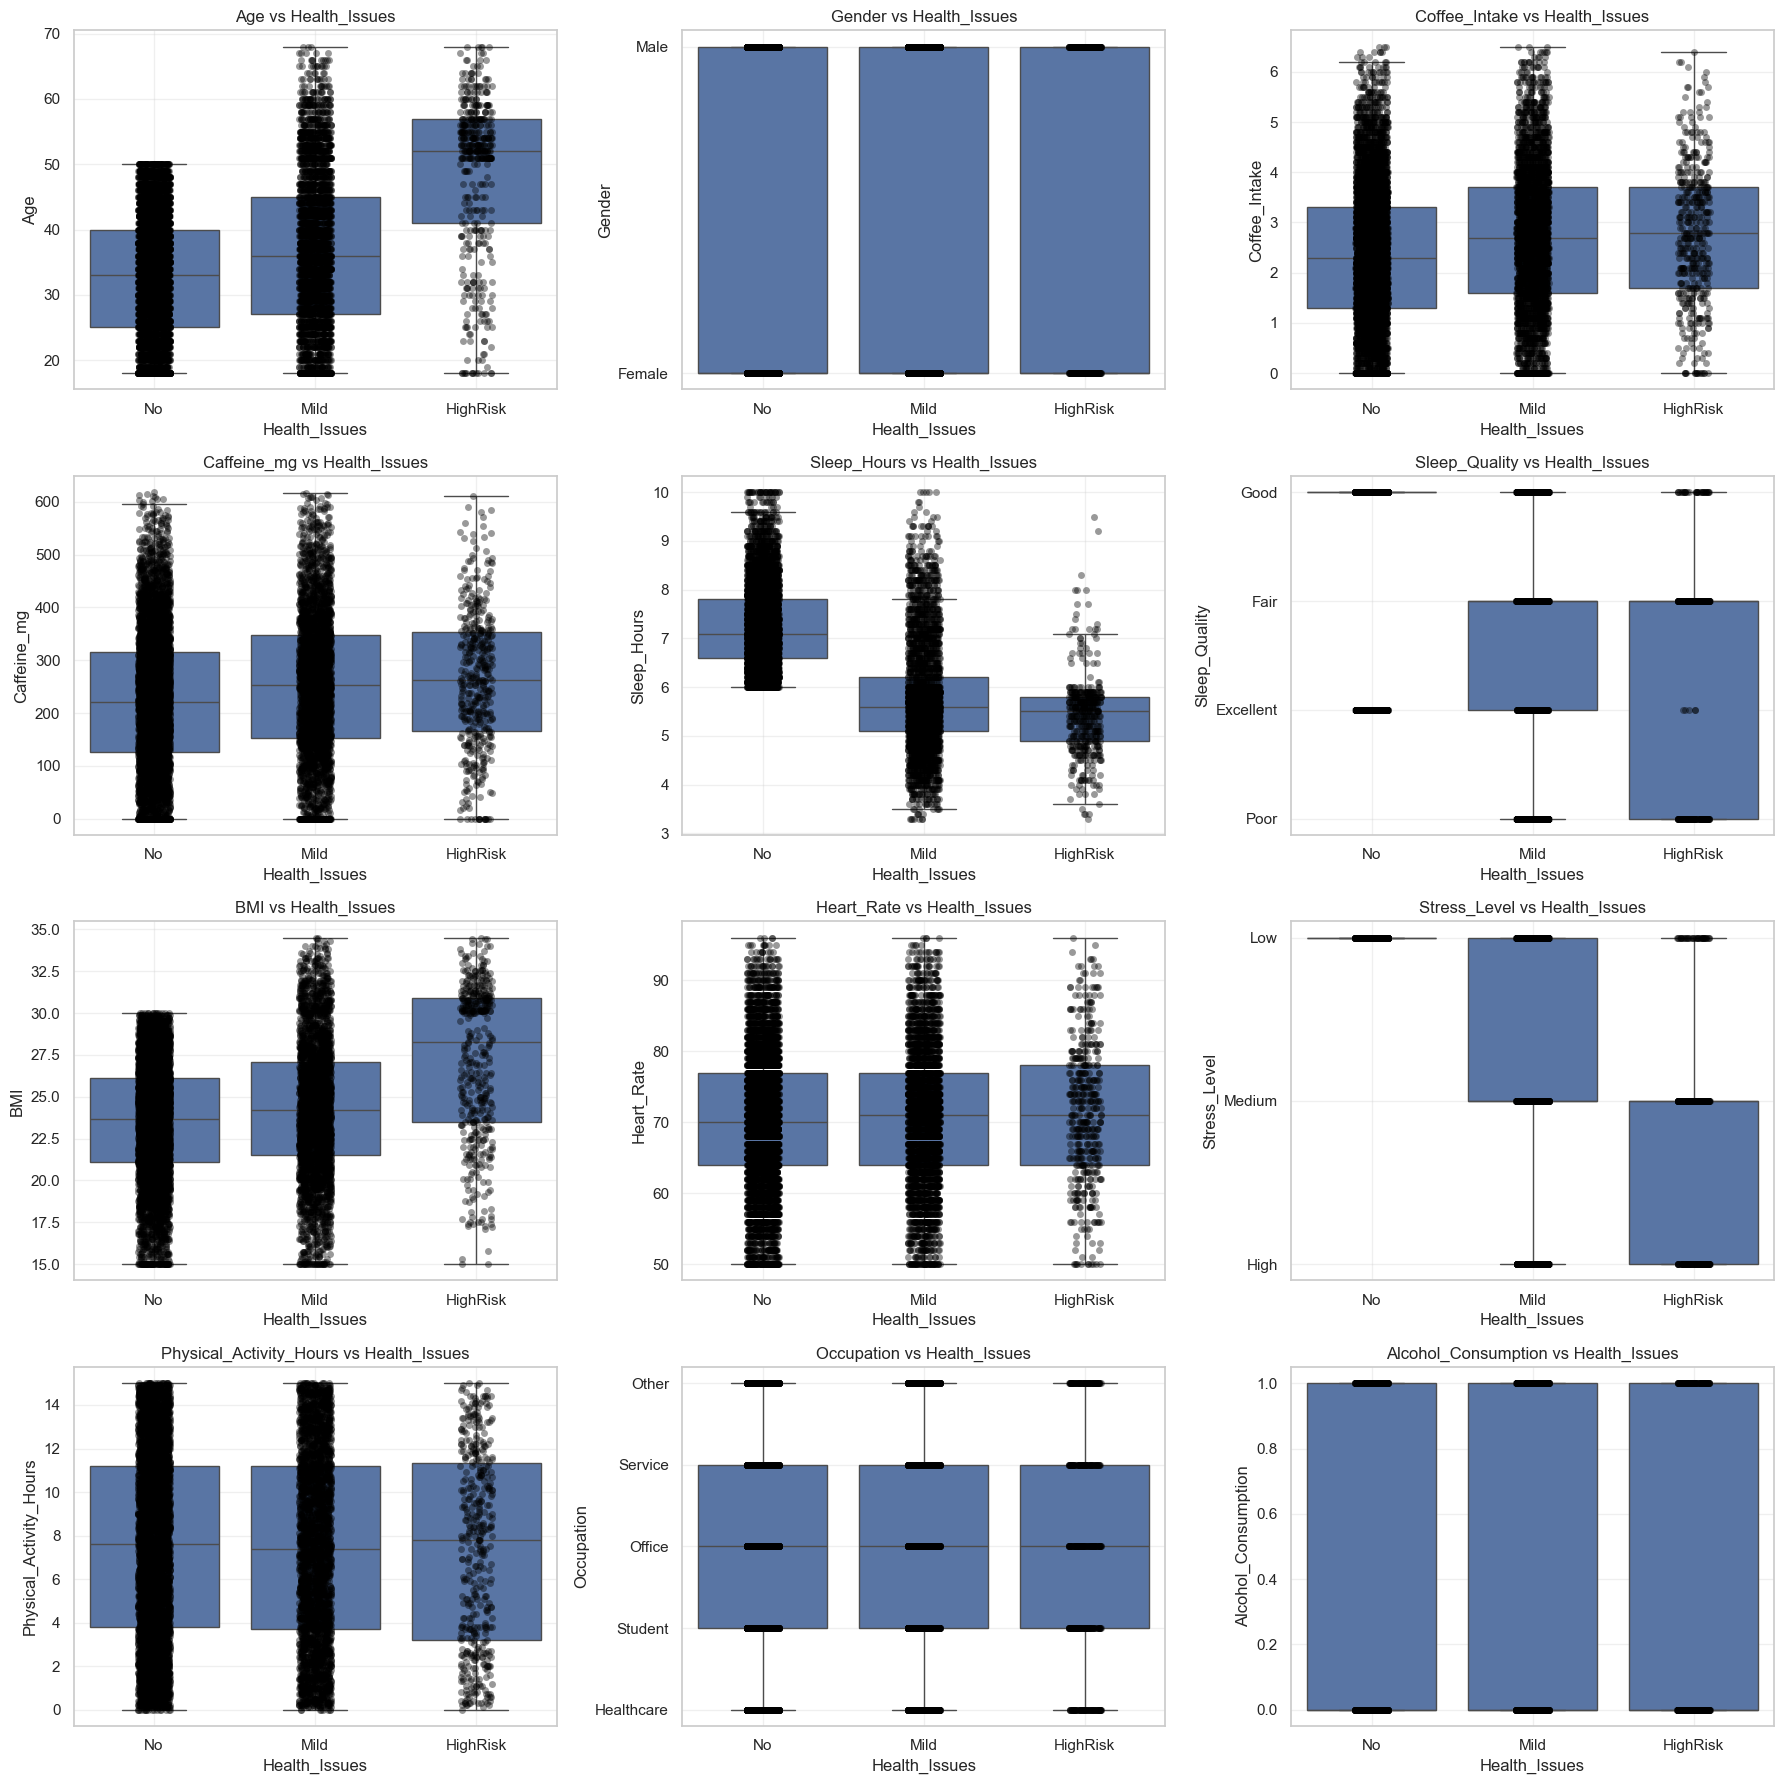

,Age,Gender,Coffee_Intake,Caffeine_mg,Sleep_Hours,Sleep_Quality,BMI,Heart_Rate,Stress_Level,Physical_Activity_Hours,Health_Issues,Occupation,Alcohol_Consumption
0,40,Male,3.5,328.1,7.5,Good,24.9,78,Low,14.5,No,Other,0
1,33,Male,1.0,94.1,6.2,Good,20.0,67,Low,11.0,No,Service,0
2,42,Male,5.3,503.7,5.9,Fair,22.7,59,Medium,11.2,Mild,Office,0
3,53,Male,2.6,249.2,7.3,Good,24.7,71,Low,6.6,Mild,Other,0
4,32,Female,3.1,298.0,5.3,Fair,24.1,76,Medium,8.5,Mild,Student,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,50,Female,2.1,199.8,6.0,Fair,30.5,50,Medium,10.1,HighRisk,Healthcare,1
9996,18,Female,3.4,319.2,5.8,Fair,19.1,71,Medium,11.6,Mild,Service,0
9997,26,Male,1.6,153.4,7.1,Good,25.1,66,Low,13.7,No,Student,1
9998,40,Female,3.4,327.1,7.0,Good,19.3,80,Low,0.1,No,Student,0


In [12]:

def detect_outliers_iqr(data, col):
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    # >1.5 (up to 3) don't change the amount of rows (a lot) so stay with the default
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

# Only apply on numerical columns
numeric_cols = sch_db.select_dtypes(include=['float64', 'int64']).columns
outliers_info = {}

for col in numeric_cols:
    print(sch_db[col].dtype)
    lb, ub = detect_outliers_iqr(sch_db, col)
    sch_db = sch_db[(sch_db[col] >= lb) & (sch_db[col] <= ub)]

show_plots(sch_db, target='Health_Issues')
# Remaining values after outliers cleaning: 7671 (for n*IQR:=1.5*IQR)
sch_db

# Data split train data vs test data

Assign Input Variable and Target Variable

In [13]:
# Target value for the classification model
x = sch_db.drop('Health_Issues', axis=1)
y = sch_db['Health_Issues']
# Since our database is a bit small (< 10k lines), we keep 25% of the data for testing purpose
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=TEST_SIZE, random_state=RD_STATE)

# Get a csv of all x and y
def all_to_csv(x_train, x_test, y_train, y_test):
    x_train.to_csv("x_train.csv")
    y_train.to_csv("y_train.csv")
    x_test.to_csv("x_test.csv")
    y_test.to_csv("y_test.csv")
    
all_to_csv(x_train, x_test, y_train, y_test)

## **Data Preprocessing**
* Goal: Prepare raw data for modelling or analysis.
* Includes data cleaning, plus additional transformations, such as:
    * Encoding categorical variables (e.g., one-hot encoding)
      + Done
    * Feature scaling (e.g., normalization, standardization)
      + Done
    * Handling imbalanced datasets
       + Done using SMOTE
    * Feature selection/extraction
       + Done
    * Data transformation (e.g., log transformations, binning)
      + Not necessary

## Label encoding

In [14]:
# Encode X with OHE

cols = ["Gender", "Sleep_Quality", "Stress_Level", "Occupation"]


def transformationEncoder(df_train, df_test, colName: str) -> pd.DataFrame:
    ohe_x = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    ohe_x.fit(df_train[[colName]])
    column_names = [colName + "_" + str(cat) for cat in ohe_x.categories_[0]]
    
    # Transform training data
    onehot_train = ohe_x.transform(df_train[[colName]])
    df_train_onehot = pd.DataFrame(onehot_train, columns=column_names, index=df_train.index)
    df_train = pd.concat([df_train.drop(colName, axis=1), df_train_onehot], axis=1)

    # Transform test data
    onehot_test = ohe_x.transform(df_test[[colName]])
    df_test_onehot = pd.DataFrame(onehot_test, columns=column_names, index=df_test.index)
    df_test = pd.concat([df_test.drop(colName, axis=1), df_test_onehot], axis=1)
    
    return df_train, df_test


# Apply label encoding to each column
for col in cols:
    x_train, x_test = transformationEncoder(x_train, x_test, col)
    
x_train

,Age,Coffee_Intake,Caffeine_mg,Sleep_Hours,BMI,Heart_Rate,Physical_Activity_Hours,Alcohol_Consumption,Gender_Female,Gender_Male,...,Sleep_Quality_Good,Sleep_Quality_Poor,Stress_Level_High,Stress_Level_Low,Stress_Level_Medium,Occupation_Healthcare,Occupation_Office,Occupation_Other,Occupation_Service,Occupation_Student
7893,22,2.9,277.3,5.1,22.0,78,13.7,0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
226,35,3.9,372.2,7.2,21.1,55,1.5,1,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4558,28,1.1,103.3,7.0,21.1,77,7.9,1,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3203,50,0.0,0.0,5.8,30.8,86,10.8,0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4205,27,3.9,368.8,5.9,21.7,73,4.6,0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5957,42,0.8,74.2,7.5,15.0,59,12.9,0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
5393,36,2.5,233.6,5.1,28.1,53,11.2,0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
5597,31,0.1,14.0,7.3,24.9,60,1.5,0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
888,42,3.0,289.5,6.7,23.1,86,7.5,1,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [15]:
# Encode Y with LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

y_train

array([1, 2, 2, ..., 2, 2, 2], shape=(7198,))

## Class balancing

In [16]:
x_train, y_train = SMOTE(random_state=RD_STATE).fit_resample(x_train, y_train)

# Random Forest

## Hypertunning

In [17]:
random_forest_classifier = RandomForestClassifier(n_jobs=-1, random_state=RD_STATE)

# Define the search space
param_distributions = {
    'n_estimators': randint(100, 500),         # Random integer between 100 and 500
    'max_depth': randint(1,11),                # Discrete list
    'min_samples_split': randint(2, 11),       # Random integer between 2 and 10
    'min_samples_leaf': randint(1, 5),         # Random integer between 1 and 4
    'max_features': ['sqrt'],                  # Categorical
}

search = RandomizedSearchCV(
    estimator=random_forest_classifier,
    param_distributions=param_distributions,
    n_iter=50, 
    cv=3, 
    scoring='recall_macro', 
    verbose=1, 
    random_state=RD_STATE,
    n_jobs=-1
)

search.fit(x_train, y_train)
print(f"Best parameters: {search.best_params_}")
print(f"Best Score: {search.best_score_}")

# The best parameters found by GridSearchCV
# 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100
# The best parameters found by RandomSearchCV
# {'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 225}

best_rf_classifier = search.best_estimator_


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 439}
Best Score: 0.9785689741963366


In [18]:
# Best model possible
best_rf_classifier = RandomForestClassifier(n_jobs=-1, random_state=RD_STATE,  **{
  'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 170
  })

## Prediction and model Evaluation

In [19]:
best_rf_classifier.fit(x_train, y_train)
y_predict = best_rf_classifier.predict(x_test)

y_predict

array([2, 2, 2, ..., 1, 0, 1], shape=(2400,))

In [20]:
# Get the evaluation metrics
knn_acc = accuracy_score(y_test, y_predict)*100
knn_pre = precision_score(y_test, y_predict, average = 'weighted')
knn_recall = recall_score(y_test, y_predict, average = 'macro')
knn_f1_ = f1_score(y_test, y_predict, average = 'weighted')

print("\nRF - Accuracy: {:.3f}".format(knn_acc))
print("RF - Precision: {:.3f}".format(knn_pre))
print("RF - Recall (macro): {:.3f}".format(knn_recall))
print("RF - F1_Score: {:.3f}".format(knn_f1_))
print ('\n Classification Report:\n', classification_report(y_test, y_predict))
print()

print('\n Confusion Matrix:\n', confusion_matrix(y_test, y_predict))



RF - Accuracy: 89.167
RF - Precision: 0.902
RF - Recall (macro): 0.831
RF - F1_Score: 0.887

 Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.77      0.86       112
           1       0.96      0.73      0.83       855
           2       0.86      1.00      0.92      1433

    accuracy                           0.89      2400
   macro avg       0.94      0.83      0.87      2400
weighted avg       0.90      0.89      0.89      2400



 Confusion Matrix:
 [[  86   26    0]
 [   1  621  233]
 [   0    0 1433]]


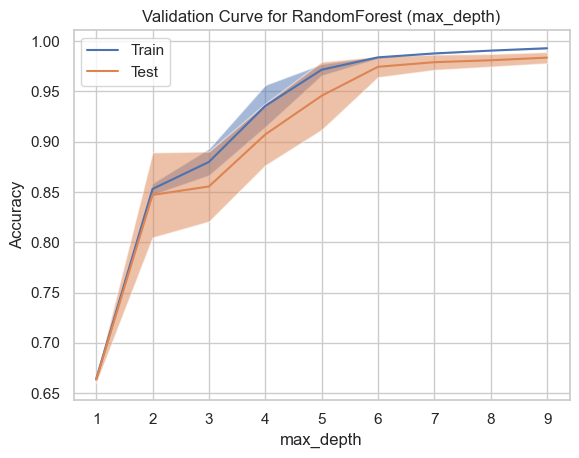

In [21]:
ValidationCurveDisplay.from_estimator(
   best_rf_classifier, x_train, y_train, param_name="max_depth", param_range=[i for i in range(1, 10)], n_jobs=-1,
   scoring="accuracy", cv=5
)

plt.title('Validation Curve for RandomForest (max_depth)')
plt.grid(True)
plt.show()

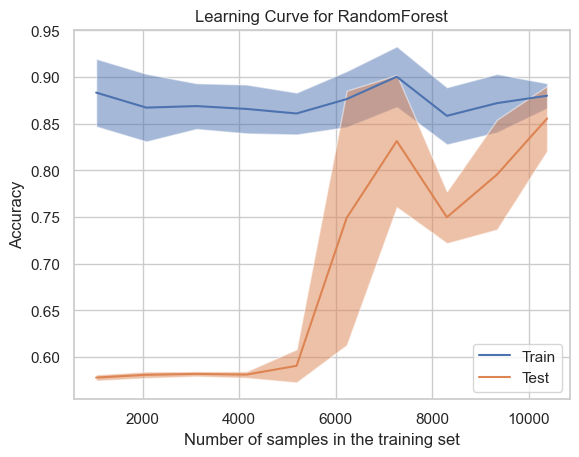

In [22]:
LearningCurveDisplay.from_estimator(
   best_rf_classifier, x_train, y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=5, n_jobs=-1,
   scoring="accuracy", random_state=RD_STATE
)

plt.title('Learning Curve for RandomForest')
plt.grid(True)
plt.show()

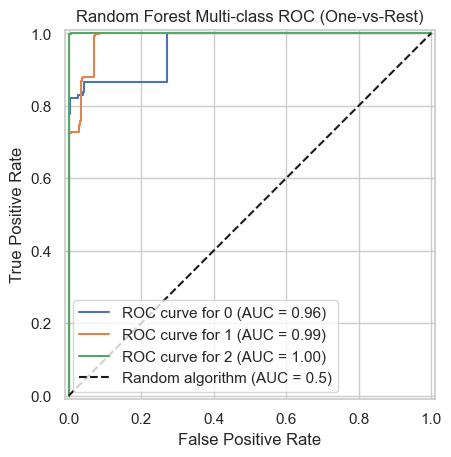

In [23]:
# Binarize labels (required for multiclass ROC)
lb = LabelBinarizer().fit(y_train)
y_onehot_test = lb.transform(y_test)
y_score_rf = best_rf_classifier.predict_proba(x_test)

fig, ax = plt.subplots()

for i, class_name in enumerate(lb.classes_):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, i],
        y_score_rf[:, i],
        name=f"ROC curve for {class_name}",
        ax=ax,
    )

plt.plot([0, 1], [0, 1], "k--", label="Random algorithm (AUC = 0.5)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Random Forest Multi-class ROC (One-vs-Rest)")
plt.grid(True)
plt.legend()
plt.show()